In [1]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata

import TomTom
import TomTom.Mesh_maker as Mesh_maker
import TomTom.Functions as Functions
import TomTom.Calc_path as Calc_path

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from scipy.spatial import Delaunay
import pickle

In [2]:
name = 'D:/DCSMv6-ZUNOv4/Noos_0418-0419_dt02_CF.nc'
nc = Dataset(name)

In [3]:
print(nc.variables.keys())

odict_keys(['y', 'VELV', 'time', 'x', 'VELU', 'VELUV_ABS', 'SEP'])


In [83]:
class flow_NOOS():
    def __init__(self, name):
        nc = Dataset(name)
        x_domain = (250,380)
        y_domain = (530,760)

        v = nc.variables['VELV'][:,:,:]
        u = nc.variables['VELU'][:,:,:]
        d = nc.variables['SEP'][:,:,:]
        x = nc.variables['x'][:,:]
        y = nc.variables['y'][:,:]
        t = nc.variables['time'][:]
        t = t *60
        x = x[x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]
        y = y[x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]
        u = u[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]
        v = v[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]
        d = d[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]

        x_temp = ma.array(x.reshape(x.size))
        y_temp = ma.array(y.reshape(x.size))

        nodes = np.zeros((y_temp[y_temp.mask == False].size,2))
        nodes[:,0] = y_temp[y_temp.mask == False]
        nodes[:,1] = x_temp[y_temp.mask == False]
        print('1/3')

        bat, nodesb = self.bat()
        Db_new = griddata((nodesb[:,1],nodesb[:,0]), bat, (x,y), method='linear')

        WD = d * 0
        for i in range(d.shape[0]):
            WD[i,:,:] = d[i,:,:] - Db_new

        print('2/3')

        u_n = []
        v_n = []
        d_n = []

        for node in nodes:
            xloc = np.argwhere(x == node[1])[0,1]
            yloc = np.argwhere(y == node[0])[0,0]
            u_n.append(u[:,yloc,xloc])
            v_n.append(v[:,yloc,xloc])
            d_n.append(WD[:,yloc,xloc])

        d_n = np.array(d_n)
        d_n[d_n < -600] = 0
        v_n = np.array(v_n)
        v_n[v_n < -600] = 0
        u_n = np.array(u_n)
        u_n[u_n < -600] = 0
        
        self.nodes = nodes
        self.u = np.transpose(u_n)
        self.v = np.transpose(v_n)
        self.WD = np.transpose(d_n)
        self.tria = Delaunay(nodes)
        self.t = t
        
    def bat(self):
        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0008_map.nc'
        b = -35

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][:b]
        y = nc.variables['mesh2d_face_y'][:b]
        nodes1 = np.zeros((len(x),2))
        nodes1[:,0] = y
        nodes1[:,1] = x
        bat1 = nc.variables['mesh2d_flowelem_bl'][:b]

        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0009_map.nc'
        a = 13
        b = -101

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][a:b]
        y = nc.variables['mesh2d_face_y'][a:b]
        nodes2 = np.zeros((len(x),2))
        nodes2[:,0] = y
        nodes2[:,1] = x
        nodes1 = np.concatenate((nodes1, nodes2, ), axis = 0)
        bat2 = nc.variables['mesh2d_flowelem_bl'][a:b]
        bat1 = np.concatenate((bat1, bat2, ), axis = 0)

        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0018_map.nc'
        b = -173

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][:b]
        y = nc.variables['mesh2d_face_y'][:b]
        nodes2 = np.zeros((len(x),2))
        nodes2[:,0] = y
        nodes2[:,1] = x
        nodes1 = np.concatenate((nodes1, nodes2, ), axis = 0)
        bat2 = nc.variables['mesh2d_flowelem_bl'][:b]
        bat1 = np.concatenate((bat1, bat2, ), axis = 0)

        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0013_map.nc'
        a = -20000
        b = -200

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][a:b]
        y = nc.variables['mesh2d_face_y'][a:b]
        nodes2 = np.zeros((len(x),2))
        nodes2[:,0] = y
        nodes2[:,1] = x
        nodes1 = np.concatenate((nodes1, nodes2, ), axis = 0)
        bat2 = nc.variables['mesh2d_flowelem_bl'][a:b]
        bat1 = np.concatenate((bat1, bat2, ), axis = 0)

        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0007_map.nc'
        b = -300

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][:b]
        y = nc.variables['mesh2d_face_y'][:b]
        nodes2 = np.zeros((len(x),2))
        nodes2[:,0] = y
        nodes2[:,1] = x
        nodes1 = np.concatenate((nodes1, nodes2, ), axis = 0)
        bat2 = nc.variables['mesh2d_flowelem_bl'][:b]
        bat1 = np.concatenate((bat1, bat2, ), axis = 0)

        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0019_map.nc'
        b = -12533

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][:b]
        y = nc.variables['mesh2d_face_y'][:b]
        nodes2 = np.zeros((len(x),2))
        nodes2[:,0] = y
        nodes2[:,1] = x
        nodes1 = np.concatenate((nodes1, nodes2, ), axis = 0)
        bat2 = nc.variables['mesh2d_flowelem_bl'][:b]
        bat1 = np.concatenate((bat1, bat2, ), axis = 0)

        name = 'D:/DCSM-FM_100m/A06_pieter/DCSM-FM_100m_0006_map.nc'
        a = -19000 + 149 
        b = -5649

        nc = Dataset(name)
        x = nc.variables['mesh2d_face_x'][a:b]
        y = nc.variables['mesh2d_face_y'][a:b]
        nodes2 = np.zeros((len(x),2))
        nodes2[:,0] = y
        nodes2[:,1] = x
        nodes = np.concatenate((nodes1, nodes2, ), axis = 0)
        bat2 = nc.variables['mesh2d_flowelem_bl'][a:b]
        bat1 = np.concatenate((bat1, bat2, ), axis = 0)

        bat1 = np.array(bat1)

        idx = np.unique(nodes, axis = 0, return_index=True)[1]       
        nodes = nodes[idx]
        bat = bat1[idx]

        return bat, nodes

In [84]:
start_time = time.time()

flow = flow_NOOS(name)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

1/3
2/3
the computational time is: 41.09 sec


In [104]:
x_r = np.arange(3,7, 0.01)
y_r = np.arange(52,55, 0.01)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((flow.nodes[:,1], flow.nodes[:,0]), flow.WD[115], (x_r, y_r), method= 'cubic')

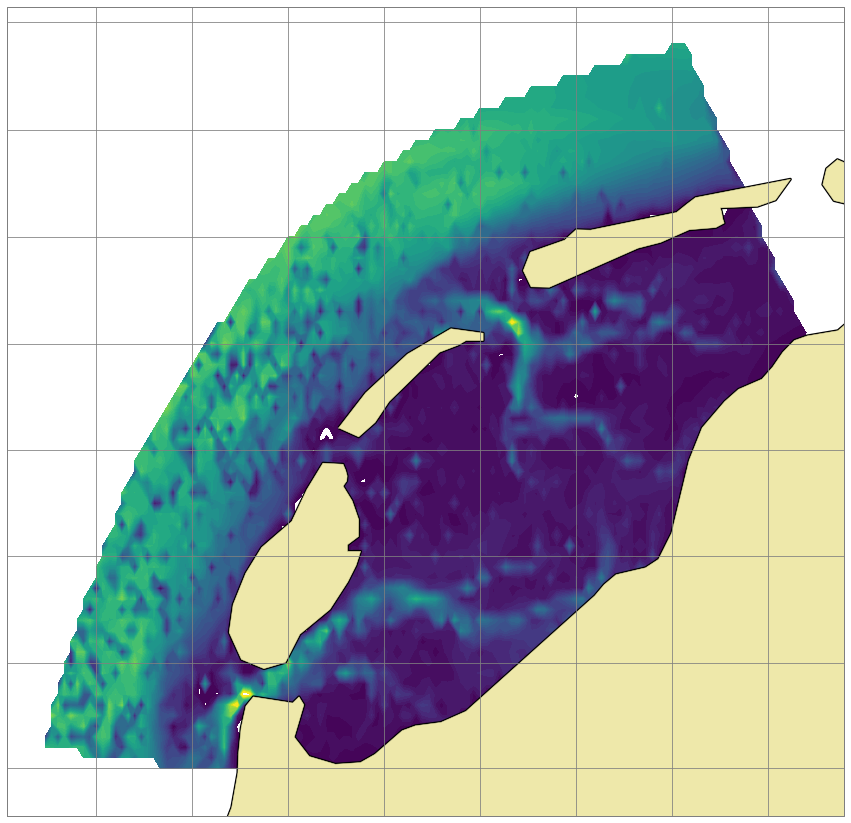

In [105]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.Mercator())

cval = np.arange(0,40,1)
plt.contourf(x_r,y_r,WD_r, cval, transform=ccrs.PlateCarree())
#cbar = plt.colorbar()

ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))